# <div style="text-align:center">Final Assignmeint in Coursera Capstone course</div>
## Exploring different cuisines (restaurants) in boroughs and neighborhoods in Toronto
## This notebook contains all calculations and visualization data which was used to cluster Toronto boroughs dependind on restaurant data from FourSquares


### 0. First: Installation of the all packages for work

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c districtdatalabs yellowbrick
!pip install folium==0.5.0
!pip install yellowbrick

### 0. And import needed modules

In [59]:
import pandas as pd
import folium
from folium import plugins
import requests
import json
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from PIL import Image
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

### 1. I used the dataset with postal codes, borougs and neighborhoods in Toronto, Canada.
### For the geospatial data I used the dataframe provided for this course.

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df=df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df['Neighbourhood']=df['Neighbourhood'].replace('Not assigned',df['Borough'])
url='http://cocl.us/Geospatial_data'
gd=pd.read_csv(url)
gd.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df.set_index('Postcode', inplace=True)
gd.set_index('Postcode', inplace=True)
mergedDf = df.merge(gd, left_index=True, right_index=True)
mergedDf=mergedDf.reset_index()
mergedDf.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 2. It's easy to show all boroughs on map using folium package. The boroughs and FSA codes are labelled on map.

In [4]:
latitude=43.653226
longitude=-79.383184


toronto_all=mergedDf.copy()
print(toronto_all.shape)
#print(toronto_all.head())

map_dots = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood, fsa in zip(toronto_all['Latitude'], toronto_all['Longitude'], toronto_all['Borough'], toronto_all['Neighbourhood'], toronto_all['Postcode']):
    label = '{}, {}'.format(borough, fsa)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#3d3c42',
        fill=True,
        fill_color='#01ffff',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_dots)  
    
map_dots

(103, 5)


### 3. Next I'm going to use Foursquares API to gather information abo

In [5]:
# The code was removed by Watson Studio for sharing.

### 4. I copied previous dataframe with all data to new dataframe and call it bn_data.

In [6]:
bn_data = mergedDf.copy()
bn_data.rename(columns={'Postcode':'FSA'}, inplace=True)
bn_data.head()

,FSA,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 5. Here is a function to get nearby venues using search query and add it to the dataframe.

In [7]:
def getNearbyRestaurants(fsa, boroughs, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for fsa, borough, name, lat, lng in zip(fsa,boroughs, names, latitudes, longitudes):
        print(fsa,' ',borough,' ',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            fsa,
            borough,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['FSA',
                             'Borough',
                             'Neighbourhood',
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [8]:
bn_restaurants = getNearbyRestaurants(fsa=bn_data['FSA'],
                                      boroughs=bn_data['Borough'],
                                      names=bn_data['Neighbourhood'],
                                      latitudes=bn_data['Latitude'],
                                      longitudes=bn_data['Longitude']
                                  )

M1B   Scarborough   Rouge,Malvern
M1C   Scarborough   Highland Creek,Rouge Hill,Port Union
M1E   Scarborough   Guildwood,Morningside,West Hill
M1G   Scarborough   Woburn
M1H   Scarborough   Cedarbrae
M1J   Scarborough   Scarborough Village
M1K   Scarborough   East Birchmount Park,Ionview,Kennedy Park
M1L   Scarborough   Clairlea,Golden Mile,Oakridge
M1M   Scarborough   Cliffcrest,Cliffside,Scarborough Village West
M1N   Scarborough   Birch Cliff,Cliffside West
M1P   Scarborough   Dorset Park,Scarborough Town Centre,Wexford Heights
M1R   Scarborough   Maryvale,Wexford
M1S   Scarborough   Agincourt
M1T   Scarborough   Clarks Corners,Sullivan,Tam O'Shanter
M1V   Scarborough   Agincourt North,L'Amoreaux East,Milliken,Steeles East
M1W   Scarborough   L'Amoreaux West
M1X   Scarborough   Upper Rouge
M2H   North York   Hillcrest Village
M2J   North York   Fairview,Henry Farm,Oriole
M2K   North York   Bayview Village
M2L   North York   Silver Hills,York Mills
M2M   North York   Newtonbrook,Will

### 6. Here is a function to eject short venue name from column with full json string with category data.

In [9]:
def get_category_type(row):
    try:
        categories_list = row['Venue Category']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['shortName']

# filter the category for each row
bn_restaurants['Venue Category'] = bn_restaurants.apply(get_category_type, axis=1)

In [10]:
print(bn_restaurants.shape)
bn_restaurants.head()

(577, 9)


,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Wonder Season Chinese Restaurant,43.765354,-79.190536,None
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant & Bar,43.774780,-79.241043,Restaurant
2,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,terry's restaurant,43.774969,-79.240872,Italian
3,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant,43.774702,-79.241175,None


### 7. I saw that my DF has None values and some values that are not exactly restaurants.

In [11]:
bn_restaurants['Venue Category'].unique()

array([None, 'Restaurant', 'Italian', 'Hakka', 'Thai', 'Indian',
       'Chinese', 'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches',
       'Furniture / Home', 'Asian', 'Diner', 'Japanese', 'Café',
       'Eastern European', 'American', 'Sushi', 'African', 'Caribbean',
       'Lounge', 'Persian', 'Lebanese', 'Mediterranean', 'Greek',
       'Ice Cream', 'Music Venue', 'Entertainment', 'Tapas',
       'New American', 'Fast Food', 'Pub', 'Movie Theater', 'Ethiopian',
       'Theme Restaurant', 'Gastropub', 'Modern European', 'Dim Sum',
       'Spanish', 'Mongolian', 'Food', 'Molecular Gastronomy', 'Beer Bar',
       'Bar', 'Szechuan', 'Vietnamese', 'French', 'Wine Bar',
       'Deli / Bodega', 'Brewery', 'Steakhouse', 'Noodles', 'Nightclub',
       'Vegetarian / Vegan', 'Cantonese', 'Dumplings', 'Portuguese',
       'Mexican', 'Cuban', 'Nightlife', 'Latin American', 'Pizza'],
      dtype=object)

### 8. I washed away all non-restaurant data.

In [12]:
bn_restaurants=bn_restaurants.dropna()
bn_restaurants.drop(bn_restaurants[(bn_restaurants['Venue Category']=='Furniture / Home') | 
                                   (bn_restaurants['Venue Category']=='Movie Theater') | 
                                   (bn_restaurants['Venue Category']=='Nightclub') | 
                                   (bn_restaurants['Venue Category']=='Nightlife') | 
                                   (bn_restaurants['Venue Category']=='Entertainment') |
                                   (bn_restaurants['Venue Category']=='Music Venue')].index,inplace=True)

In [13]:
bn_restaurants['Venue Category'].unique()

array(['Restaurant', 'Italian', 'Hakka', 'Thai', 'Indian', 'Chinese',
       'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches', 'Asian',
       'Diner', 'Japanese', 'Café', 'Eastern European', 'American',
       'Sushi', 'African', 'Caribbean', 'Lounge', 'Persian', 'Lebanese',
       'Mediterranean', 'Greek', 'Ice Cream', 'Tapas', 'New American',
       'Fast Food', 'Pub', 'Ethiopian', 'Theme Restaurant', 'Gastropub',
       'Modern European', 'Dim Sum', 'Spanish', 'Mongolian', 'Food',
       'Molecular Gastronomy', 'Beer Bar', 'Bar', 'Szechuan',
       'Vietnamese', 'French', 'Wine Bar', 'Deli / Bodega', 'Brewery',
       'Steakhouse', 'Noodles', 'Vegetarian / Vegan', 'Cantonese',
       'Dumplings', 'Portuguese', 'Mexican', 'Cuban', 'Latin American',
       'Pizza'], dtype=object)

In [14]:
print('There are {} uniques categories.'.format(len(bn_restaurants['Venue Category'].unique())))
print('There are {} uniques boroughs.'.format(len(bn_restaurants['Borough'].unique())))
print('There are {} uniques neighborhoods.'.format(len(bn_restaurants['Neighbourhood'].unique())))
print('There are {} venues.'.format((bn_restaurants['Venue'].count())))

There are 56 uniques categories.
There are 10 uniques boroughs.
There are 57 uniques neighborhoods.
There are 557 venues.


### 9.  I was interested in visualization of restaurants count in each borough so I decided to draw a choropleth map.
### There was no geojson file on the internet so I did it myself using this tutorial: [Tutorial](https://medium.com/dataexplorations/generating-geojson-file-for-toronto-fsas-9b478a059f04)
### You can find my final geojson file in my Github repository, feel free to use it!

In [15]:
bn_grouped=bn_restaurants.copy()
#bn_grouped=bn_grouped.groupby(['FSA','Borough','Neighbourhood'])['Venue Category'].apply(','.join).reset_index()
bn_grouped=bn_grouped.groupby(['FSA'])['Venue'].count().reset_index()
bn_grouped.rename(columns={'Venue':'Count'}, inplace=True)

#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
bn_grouped.head()

,FSA,Count
0,M1H,4
1,M1P,2
2,M1R,3
3,M1S,4
4,M1T,3


In [16]:
!wget --quiet https://raw.githubusercontent.com/azulgris/coursera_capstone/master/Toronto_Map_FSA.geojson -O Toronto_Map_FSA.geojson
t_js=r'Toronto_Map_FSA.geojson'
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


### 10.  I'll use DF with geospatial data to add labels with postcode.

In [17]:
fsa_geo=mergedDf.loc[:,['Postcode','Borough','Latitude','Longitude']]
fsa_geo.drop(fsa_geo[fsa_geo['Postcode']=='M7R'].index,inplace=True)
print(fsa_geo.shape)
fsa_geo.head()

(102, 4)


,Postcode,Borough,Latitude,Longitude
0,M1B,Scarborough,43.806686,-79.194353
1,M1C,Scarborough,43.784535,-79.160497
2,M1E,Scarborough,43.763573,-79.188711
3,M1G,Scarborough,43.770992,-79.216917
4,M1H,Scarborough,43.773136,-79.239476


### 11. Here is the map with clustered labels and color-graded data.

In [18]:
latitude=43.653226
longitude=-79.383184
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

toronto_map.choropleth(geo_data=t_js,
    data = bn_grouped,
    columns=['FSA','Count'],
    key_on='feature.properties.CFSAUID',
    fill_color='PuRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurants by FSA') 


# instantiate a mark cluster object for the incidents in the dataframe
rests = plugins.MarkerCluster().add_to(toronto_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(fsa_geo['Latitude'], fsa_geo['Longitude'], fsa_geo['Postcode']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(rests)   
    
toronto_map

### 12. Checking DF with venues.

In [19]:
bn_restaurants.head()

,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant & Bar,43.774780,-79.241043,Restaurant
2,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,terry's restaurant,43.774969,-79.240872,Italian
3,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai One On,43.774468,-79.241268,Thai
6,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian


### 13. I'd like to see how is data distributed through boroughs and neighborhoods when using only cuisine-based restaurants so here it is some visualization of tops.

In [20]:
topvenues=bn_restaurants.copy()
topvenues=topvenues.groupby(['Venue Category']).count().reset_index()
cuisines=('Chinese', 'Japanese', 'Italian', 'Asian','American', 'Indian', 'Caribbean', 'Thai', 'New American',
       'Vietnamese', 'Greek', 'Middle Eastern','Mongolian', 'Korean', 'Spanish',
       'Latin American', 'Eastern European', 'Szechuan', 'French', 'African', 'Mexican',
       'Modern European', 'Portuguese', 'Hakka', 'Cuban', 'Ethiopian', 'Persian',
    'Deli / Bodega', 'Lebanese', 'Cantonese', 'Mediterranean')

topvenues=topvenues.loc[:,['Venue Category','FSA']]
topvenues.rename(columns={'FSA':'Count'},inplace=True)

topvenues.sort_values(by='Count', ascending=True, inplace=True)
topvenues=topvenues[topvenues['Venue Category'].isin(cuisines)]
topvenues.set_index('Venue Category', inplace=True)
cu_top10 = topvenues['Count'].tail(10)
cu_top10.head()

Venue Category
New American    10
Vietnamese      10
Thai            10
Caribbean       12
Indian          19
Name: Count, dtype: int64

In [21]:
topboroughs=bn_restaurants.copy()
#delete Restaurants without Cuisine
topboroughs=topboroughs[topboroughs['Venue Category'].isin(cuisines)]
topboroughs=topboroughs.groupby(['Borough']).count().reset_index()
topboroughs=topboroughs.loc[:,['Borough','FSA']]
topboroughs.rename(columns={'FSA':'Count'},inplace=True)
topboroughs.sort_values(by='Count', ascending=True, inplace=True)
topboroughs.set_index('Borough', inplace=True)
topboroughs = topboroughs['Count'].tail(10)
topboroughs.head()

Borough
Etobicoke          1
Mississauga        1
York               2
East York          5
Central Toronto    7
Name: Count, dtype: int64

In [22]:
print(plt.style.available)

['seaborn-notebook', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'seaborn-pastel', 'dark_background', 'seaborn-bright', 'seaborn-darkgrid', 'classic', '_classic_test', 'seaborn-poster', 'seaborn-ticks', 'seaborn-white', 'seaborn-talk', 'grayscale', 'fast', 'ggplot', 'seaborn-dark', 'bmh', 'seaborn-dark-palette', 'seaborn-muted', 'fivethirtyeight', 'seaborn-colorblind', 'seaborn-whitegrid', 'seaborn-deep', 'tableau-colorblind10']


In [23]:
# The code was removed by Watson Studio for sharing.

### 14. Here are the barh plots.

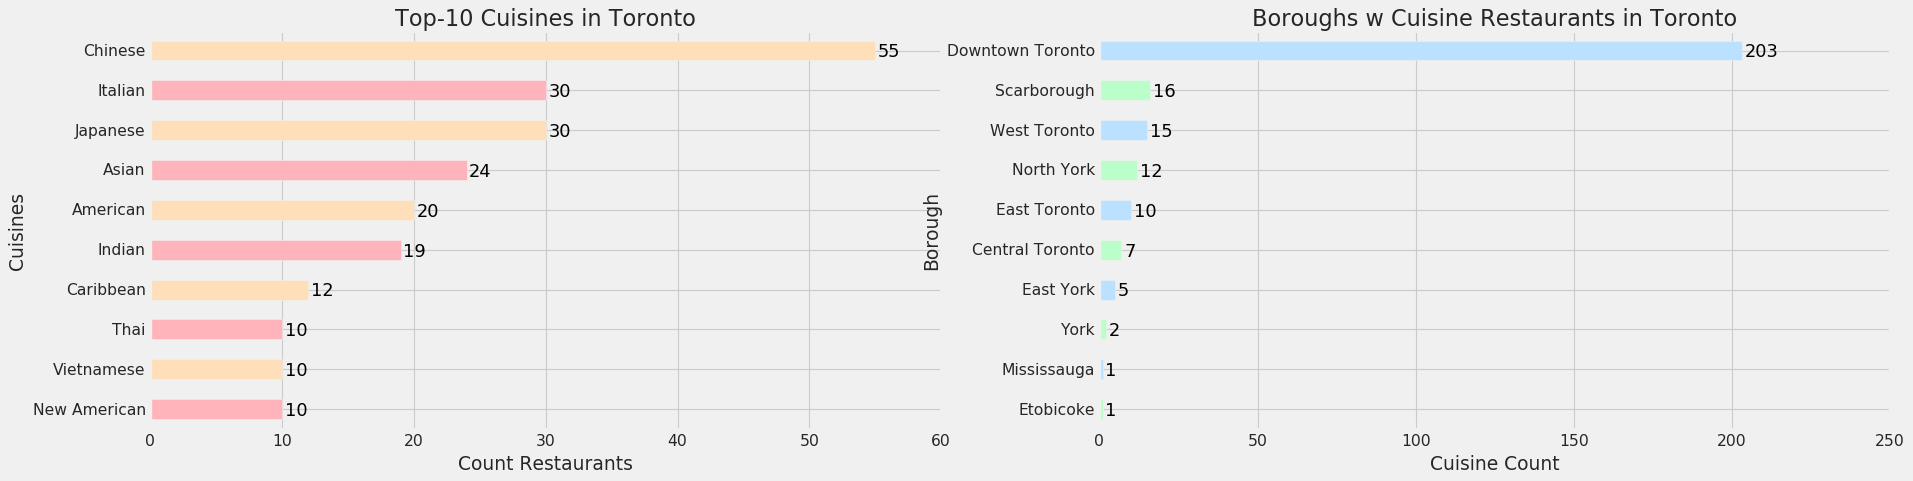

In [24]:
plt.style.use('fivethirtyeight')
colors1=['#ffb3ba','#ffdfba']
colors2=['#baffc9','#bae1ff']
colors=['#ffb3ba','#ffdfba','#ffffba','#baffc9','#bae1ff']

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
cu_top10.plot(kind='barh', figsize=(25,6), color=colors1, ax=ax0) # add to subplot 1
for a in ax0.patches:
    #print(a,' ',str(a.get_y()))
    ax0.annotate(str(a.get_width()),(a.get_width()+0.2,a.get_y()+0.1), color='black',fontsize=16)
ax0.set_xlabel('Count Restaurants')
ax0.set_ylabel('Cuisines')
ax0.set_title('Top-10 Cuisines in Toronto')

# Subplot 2: Line plot
topboroughs.plot(kind='barh', figsize=(25,6), color=colors2, ax=ax1) # add to subplot 2
for a in ax1.patches:
    #print(a,' ',str(a.get_y()))
    ax1.annotate(str(a.get_width()),(a.get_width()+0.9,a.get_y()+0.1), color='black',fontsize=16)
ax1.set_xlabel('Cuisine Count')
ax1.set_ylabel('Borough')
ax1.set_title('Boroughs w Cuisine Restaurants in Toronto')
#ax1.legend([])
#ax1.get_legend().remove()

plt.show()

### 15. But what about all cuisines in Toronto? How much of them are presented? Let's show it on a wafflechart.

In [25]:
cuisines_all=topvenues.reset_index()
#cuisines_all.sort_values(by='Count', ascending=False, inplace=True)
cuisines_all.set_index(['Venue Category'],inplace=True)
cuisines_all.head()

,Count
Venue Category,
Mediterranean,1
Ethiopian,1
Deli / Bodega,1
Cuban,1
Hakka,1


In [26]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):
    
    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    #print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
   # for i, tiles in enumerate(tiles_per_category):
   #     print (cuisines_all.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()
    #dark backgr
    #plt.style.use('dark_background')
    #plt.style.use('seaborn-dark-palette')

    # use matshow to display the waffle chart
   # colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    #plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_title('Cuisines Count', fontsize=14)
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    #ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.xticks([])
    plt.yticks([])
   
    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
            #label_str = category 
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            #label_str = category
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        #ncol=len(categories),
        ncol=5,
        bbox_to_anchor=(0.,-1.2,1,0.)
    )

### 16. So, Asian&Chinese are the most popular.

<Figure size 640x480 with 0 Axes>

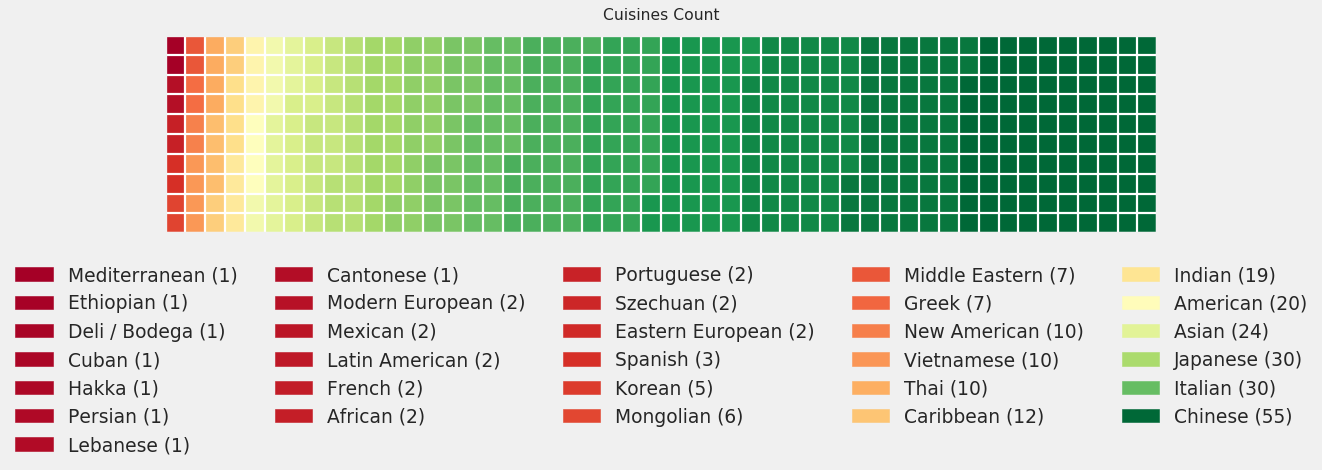

In [27]:
#mpl.cm.get_cmap(name=None, lut=None)
#bbox_to_anchor=(0., -0.2, 0.95, .1)
plt.style.use('fivethirtyeight')
width = 50 # width of chart
height = 10 # height of chart

categories = cuisines_all.index.values # categories
values = cuisines_all['Count'] # correponding values of categories

colormap = plt.cm.RdYlGn # color map class

create_waffle_chart(categories, values, height, width, colormap)

### 17.  I saw that in Downtown Toronto was literally the half of the restaurants, but what about neighborhoods? How cuisines are distributed there? Let's see.

In [28]:
dwtnwn_tor=bn_restaurants.copy()
dwtnwn_tor=dwtnwn_tor[dwtnwn_tor['Venue Category'].isin(cuisines)]
dwtnwn_tor = dwtnwn_tor[dwtnwn_tor['Borough'].str.contains('Downtown Toronto')].reset_index(drop=True)
dwtnwn_tor.head()

,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Tender Trap Restaurant,43.667724,-79.369485,Chinese
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Rainbow Restaurant,43.667416,-79.369350,Indian
2,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Athenas Bar & Restaurant,43.664134,-79.366248,Greek
3,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Ehwa Restaurant,43.667861,-79.384884,Asian
4,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Carlton Restaurant,43.661533,-79.381012,New American


In [29]:
dwtnwn_tor_onehot = pd.get_dummies(dwtnwn_tor[['Venue Category']], prefix="", prefix_sep="")
dwtnwn_tor_onehot.head()

,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
dwtnwn_tor_onehot['Neighbourhood'] = dwtnwn_tor['Neighbourhood'] 
fixed_columns1 = [dwtnwn_tor_onehot.columns[-1]] + list(dwtnwn_tor_onehot.columns[:-1])
dwtnwn_tor_onehot = dwtnwn_tor_onehot[fixed_columns1]
dwtnwn_tor_onehot.head()

,Neighbourhood,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
0,"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Cabbagetown,St. James Town",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"Cabbagetown,St. James Town",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Church and Wellesley,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Church and Wellesley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 18. At this time I've got a table with neighborhoods and venues listed. All that should be done is to group the data.

In [31]:
dwtnwn_tor['Venue Category'].unique()

array(['Chinese', 'Indian', 'Greek', 'Asian', 'New American', 'Italian',
       'Thai', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese'], dtype=object)

In [32]:
cuisines_dwntwn=['Chinese', 'Indian', 'Greek', 'New American', 'Asian', 'Thai',
       'Italian', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese']

In [33]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts()
dwtnwn_tor_grouped.head()

Neighbourhood           Venue Category
Adelaide,King,Richmond  Chinese           4
                        Indian            3
                        Japanese          3
                        American          2
                        Asian             2
Name: Venue Category, dtype: int64

In [34]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts().unstack().fillna(0).astype(int)
print(dwtnwn_tor_grouped.shape)
#pd.set_option('display.max_columns', None)
dwtnwn_tor_grouped.head()

(16, 22)


Venue Category,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0,2,2,0,2,4,0,0,0,1,3,2,3,0,1,0,0,1,0,0,0,1
Berczy Park,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
Central Bay Street,0,3,1,0,1,10,0,0,1,0,1,2,2,0,2,1,0,0,0,2,1,1
"Chinatown,Grange Park,Kensington Market",0,0,3,1,1,19,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,5


### 19.  But the pivot table is not so handy to visualize. Let's turn it into a regular DF.

In [35]:
flattened = pd.DataFrame(dwtnwn_tor_grouped.to_records())
flattened['Total']=flattened.sum(axis=1)
flattened.sort_values(by='Total', ascending=True, inplace=True)
flattened.drop(['Total'], axis=1, inplace=True)
flattened=flattened.set_index('Neighbourhood')


flattened.head()

,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,
Christie,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
"Harbord,University of Toronto",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
Berczy Park,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
Harbourfront,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### 20. That's better. Now I could present the data in barh plot. And chinese cuisine is the winner once more!

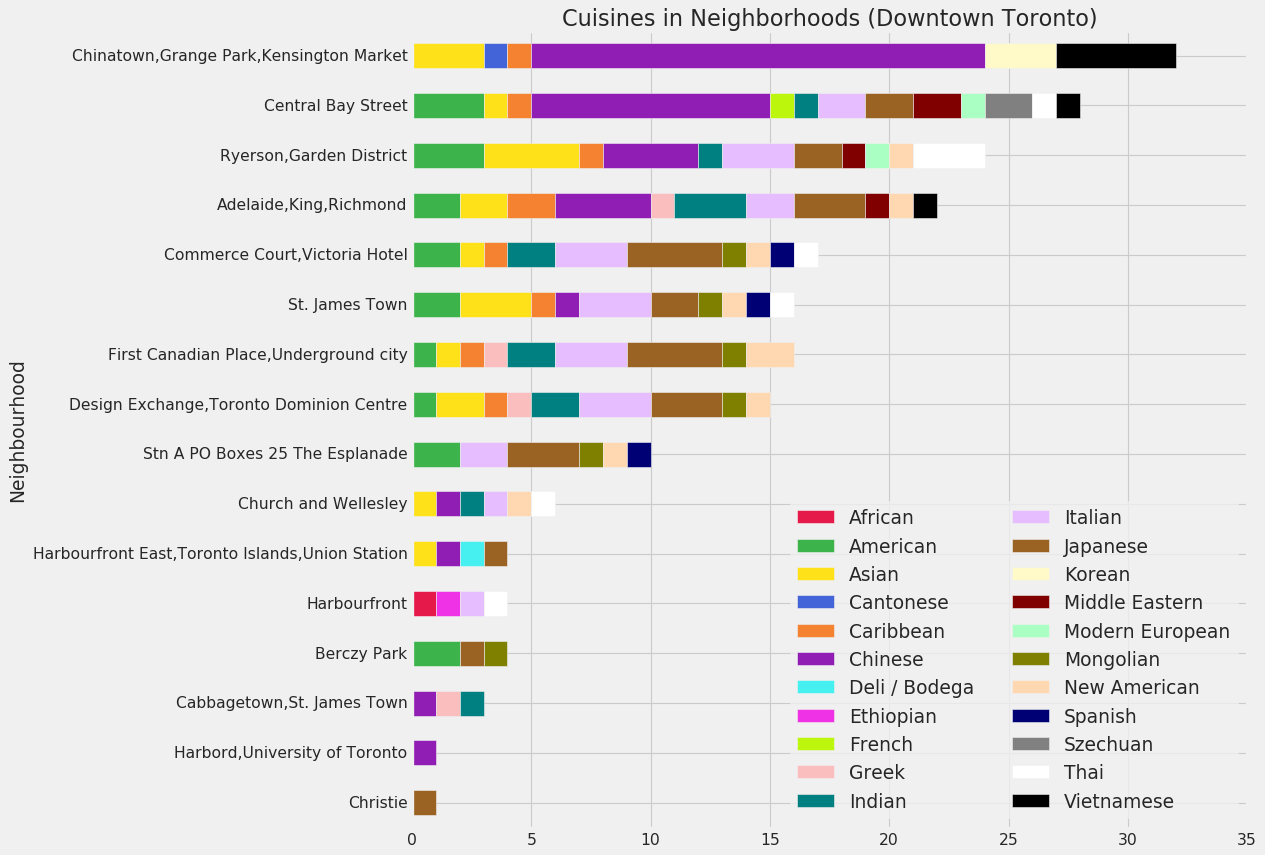

In [36]:
distinctcolors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
              '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
              '#000075', '#808080', '#ffffff', '#000000']
ax=flattened.plot.barh(stacked=True,figsize=(12,12),color=distinctcolors);
ax.set_title('Cuisines in Neighborhoods (Downtown Toronto)')
ax.legend(loc='best',ncol=2,frameon=True,framealpha=0.8)
#

### 21. Now for the science part. I thought that it may be useful to cluster boroughs by the type of the restaurants they have.
### At first, we've got to list all kinds of them in one table.

In [37]:
topneighs=bn_restaurants.copy().reset_index()
#topneighs=topneighs[topneighs['Venue Category'].isin(cuisines)]
topneighs_onehot = pd.get_dummies(topneighs[['Venue Category']], prefix="", prefix_sep="")
topneighs_onehot['Borough'] = topneighs['Borough'] 
fixed_columns = [topneighs_onehot.columns[-1]] + list(topneighs_onehot.columns[:-1])
topneighs_onehot = topneighs_onehot[fixed_columns]
topneighs_onehot.head()

,Borough,African,American,Asian,Bar,Beer Bar,Breakfast,Brewery,Café,Cantonese,Caribbean,Chinese,Cuban,Deli / Bodega,Dim Sum,Diner,Dumplings,Eastern European,Ethiopian,Fast Food,Food,French,Gastropub,Greek,Hakka,Ice Cream,Indian,Italian,Japanese,Korean,Latin American,Lebanese,Lounge,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Mongolian,New American,Noodles,Persian,Pizza,Portuguese,Pub,Restaurant,Sandwiches,Spanish,Steakhouse,Sushi,Szechuan,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wine Bar
0,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Scarborough,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 22. Second, group them to show the mean value for every venue.

In [38]:
topneighs_grouped = topneighs_onehot.groupby('Borough').mean().reset_index()
topneighs_grouped

,Borough,African,American,Asian,Bar,Beer Bar,Breakfast,Brewery,Café,Cantonese,Caribbean,Chinese,Cuban,Deli / Bodega,Dim Sum,Diner,Dumplings,Eastern European,Ethiopian,Fast Food,Food,French,Gastropub,Greek,Hakka,Ice Cream,Indian,Italian,Japanese,Korean,Latin American,Lebanese,Lounge,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Mongolian,New American,Noodles,Persian,Pizza,Portuguese,Pub,Restaurant,Sandwiches,Spanish,Steakhouse,Sushi,Szechuan,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wine Bar
0,Central Toronto,0.000000,0.000000,0.076923,0.000000,0.00000,0.153846,0.000000,0.000000,0.000000,0.000000,0.076923,0.00,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.153846,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.076923,0.076923,0.000000,0.00000,0.076923,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000
1,Downtown Toronto,0.002268,0.040816,0.043084,0.020408,0.00907,0.031746,0.002268,0.000000,0.002268,0.020408,0.095238,0.00,0.002268,0.015873,0.043084,0.002268,0.000000,0.002268,0.047619,0.002268,0.002268,0.015873,0.009070,0.000000,0.000000,0.029478,0.052154,0.058957,0.006803,0.00,0.000000,0.006803,0.000000,0.00,0.009070,0.004535,0.013605,0.013605,0.020408,0.002268,0.000000,0.00,0.00,0.018141,0.190476,0.045351,0.006803,0.00907,0.043084,0.004535,0.000000,0.018141,0.004535,0.002268,0.015873,0.013605
2,East Toronto,0.000000,0.000000,0.055556,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.00,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.055556,0.055556,0.055556,0.000000,0.000000,0.00,0.055556,0.000000,0.055556,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.00,0.00,0.000000,0.277778,0.000000,0.000000,0.00000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,East York,0.125000,0.125000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.00,0.000000,0.125000,0.000000,0.00,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.125000,0.000000,0.000000,0.00000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Etobicoke,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Mississauga,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,North York,0.000000,0.000000,0.090909,0.000000,0.00000,0.000000,0.000000,0.045455,0.000000,0.000000,0.045455,0.00,0.000000,0.000000,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.090909,0.136364,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.272727,0.045455,0.000000,0.00000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0

### 23. And third, gather the most common 5 venues for each neighborhood.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = topneighs_grouped['Borough']

for ind in np.arange(topneighs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(topneighs_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central Toronto,Breakfast,Italian,Sushi,Eastern European,Chinese
1,Downtown Toronto,Restaurant,Chinese,Japanese,Italian,Fast Food
2,East Toronto,Restaurant,Greek,Ice Cream,Sushi,Persian
3,East York,African,Sushi,Indian,Middle Eastern,Caribbean
4,Etobicoke,Pizza,Korean,Café,Fast Food,Dim Sum


### 24. To apply the kNN method we should calculate the K value first. For that I use common scikit functions to fit the model and then calculate squared error. Yellowbrick could help to visualize all process and say what K value should be used.

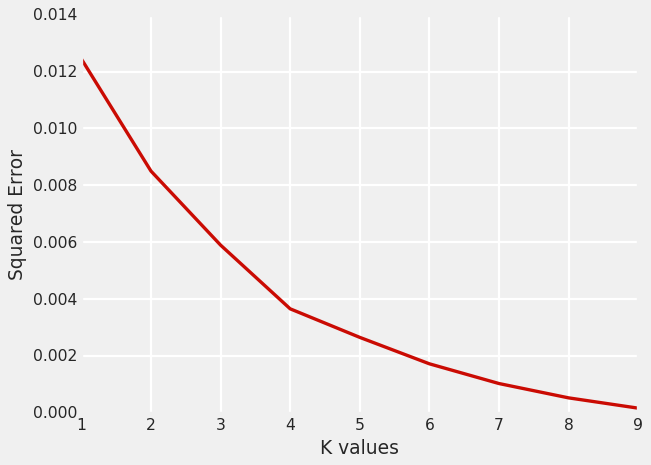

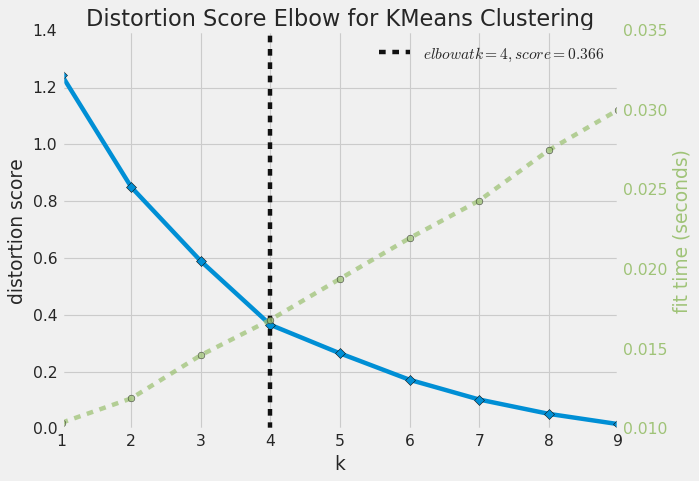

In [53]:
neighborhoods_clustering=topneighs_grouped.drop('Borough',1)


error_cost=[]

for i in range(1,10):
    KM=KMeans(n_clusters=i,max_iter=100)
    KM.fit(neighborhoods_clustering)
    error_cost.append(KM.inertia_/100)
    
plt.plot(range(1,10),error_cost,color='r',linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error')
plt.grid(color='white',linestyle='-',linewidth=2)
plt.show()


model=KMeans()
visualizer=KElbowVisualizer(model,k=(1,10))
visualizer.fit(neighborhoods_clustering)
visualizer.show()

### 25. Here it is! K=7. Let's add cluster labels to our data frame.

In [54]:
# set number of clusters
kclusters = 4
topneighs_grouped_clustering = topneighs_grouped.drop('Borough', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(topneighs_grouped_clustering)
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 0, 2, 0, 2, 3], dtype=int32)

In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
topneighs_merged = toronto_all
topneighs_merged = topneighs_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')
topneighs_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Chinese,Indian,Breakfast,Restaurant,Italian


In [56]:
topneighs_merged=topneighs_merged.dropna()
topneighs_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Chinese,Indian,Breakfast,Restaurant,Italian
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Chinese,Indian,Breakfast,Restaurant,Italian


### 26. The final result with labels is here, now we could add it to the map.

In [57]:
topneighs_merged['Cluster Labels'] = topneighs_merged['Cluster Labels'].astype(int)
topneighs_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Chinese,Indian,Breakfast,Restaurant,Italian
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Chinese,Indian,Breakfast,Restaurant,Italian
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Chinese,Indian,Breakfast,Restaurant,Italian
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Chinese,Indian,Breakfast,Restaurant,Italian
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Chinese,Indian,Breakfast,Restaurant,Italian


In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(topneighs_merged['Latitude'], topneighs_merged['Longitude'], topneighs_merged['Neighbourhood'], topneighs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 27. I explored each cluster to see how are the boroughs grouped.

In [61]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 0, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
1,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
2,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
3,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
4,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
5,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
6,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
7,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
8,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian
9,Scarborough,0,Chinese,Indian,Breakfast,Restaurant,Italian


In [62]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 1, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
88,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
89,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
90,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
91,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
92,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
94,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
95,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
99,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
100,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum
101,Etobicoke,1,Pizza,Korean,Café,Fast Food,Dim Sum


In [63]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 2, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
18,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
19,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
20,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
21,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
22,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
23,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
24,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
25,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches
26,North York,2,Restaurant,Japanese,Italian,Asian,Sandwiches


In [64]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 3, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
73,York,3,Bar,Caribbean,Chinese,Wine Bar,Dumplings
74,York,3,Bar,Caribbean,Chinese,Wine Bar,Dumplings
80,York,3,Bar,Caribbean,Chinese,Wine Bar,Dumplings
81,York,3,Bar,Caribbean,Chinese,Wine Bar,Dumplings
98,York,3,Bar,Caribbean,Chinese,Wine Bar,Dumplings
